In [55]:
# cv to optimize hyperparameter K (window len) (in principle we expect an avg len of SP of 22)
# hyperparameters are K, gamma(sd of gaussian kernel) and c
# POSSIBLE FEATURES
# hydrophobicity profile along the SP (sliding window of 5), after we extract only the avg and max hp from the profile; encode also pos in which there is the max value, 
# soe cases of SP are enriched of + resdues in the N-terminal

# normalize hp avg and max????
# add also positivily charged max and pos features?

In [56]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, mannwhitneyu, sem,normaltest,shapiro,levene

import re
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import matthews_corrcoef,precision_score, recall_score,accuracy_score, confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis as pa

def encode(df,K,c_comp=False,local_hp=False,local_hp2=False,K2=False,win=False,features_filter=False,ch=False):
    #add X = 0 to avoid warning regarding unknown aa
    hp_scale = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2, 'X':0.0, 'Z': 0.0, 'B': 0,'U':0}
    
    ch_scale = {"A": 0, "R": 1, "N": 0, "D": 0, "C": 0, "Q": 0, "E": 0, "G": 0, "H": 1, "I": 0, "L": 0, "K": 1, "M": 0, "F": 0, "P": 0, "S": 0, "T": 0, "W": 0, "Y": 0, "V": 0,'X':0,'Z':0,'B':0}
    
    columns = ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'K1', 'L1', 'M1', 'N1', 'P1', 'Q1', 'R1', 'S1', 'T1', 'V1', 'W1', 'Y1']

    # n_term comosition-------------------------------------------------------------------------------------------------------------------
    n_comp = np.empty((0, 20)) 
    for index,row in df.iterrows():
        seq = pa(row['Sequence'][:K])
        profile = np.array(list(seq.get_amino_acids_percent().values()))
        n_comp = np.vstack((n_comp,profile))
    enc_array = n_comp
    
    # c_term composition-----------------------------------------------------------------------------------------------------------------
    if c_comp:
        c_comp = np.empty((0, 20)) 
        for index,row in df.iterrows():
            seq = pa(row['Sequence'][K:])
            profile = np.array(list(seq.get_amino_acids_percent().values()))
            c_comp = np.vstack((c_comp,profile))
        enc_array = np.hstack((enc_array,c_comp))
        columns.extend(['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'K2', 'L2', 'M2', 'N2', 'P2', 'Q2', 'R2', 'S2', 'T2', 'V2', 'W2', 'Y2'])
    # local hydrophobicity window(7) from 0 to K -> avg, max and argmax(pos)-----------------------------------------------------------
    if local_hp:
        local_hp = np.empty((0, 3)) 
        for index,row in df.iterrows():
            profile = pa.protein_scale(pa(row['Sequence'][:K]),param_dict=hp_scale, window=7, edge=1.0)  #7
            features = np.array([np.argmax(profile)/K, np.max(profile),np.average(profile)])
            local_hp = np.vstack((local_hp,features))
        local_hp[:,1] = (local_hp[:,1]+4.5)/9      #normalize
        local_hp[:,2] = (local_hp[:,2]+4.5)/9
        enc_array = np.hstack((enc_array,local_hp))
        columns.extend(['HP max pos','HP max','HP avg'])

    # local hydrophobicity window(12) from 0 to K2 -> avg, max and argmax(pos)

    if local_hp2:
        local_hp2 = np.empty((0, 3)) 
        for index,row in df.iterrows():
            profile = pa.protein_scale(pa(row['Sequence'][:K2]),param_dict=hp_scale, window=win, edge=1.0)  #12
            features = np.array([np.argmax(profile)/K2, np.max(profile),np.average(profile)])
            local_hp2 = np.vstack((local_hp2,features))
        local_hp2[:,1] = (local_hp2[:,1]+4.5)/9    #normalize
        local_hp2[:,2] = (local_hp2[:,2]+4.5)/9
        enc_array = np.hstack((enc_array,local_hp2))    
        columns.extend(['HP2 max pos','HP2 max','HP2 avg'])   
    
    if ch:
        ch = np.empty((0, 3)) 
        for index,row in df.iterrows():
            profile = pa.protein_scale(pa(row['Sequence'][:K]),param_dict=ch_scale, window=5, edge=1.0)  
            features = np.array([np.argmax(profile)/K, np.max(profile),np.average(profile)])
            ch = np.vstack((ch,features))
        enc_array = np.hstack((enc_array,ch))  
        columns.extend(['CH max pos','CH max','CH avg'])   

    enc_array = pd.DataFrame(enc_array, columns=columns)
    if features_filter != False: enc_array = enc_array[features_filter]
    return enc_array

### Dataset preparation

In [57]:
#! conda install biopython -y
#random forest to perform feature selection
#to search scales by code
#https://www.genome.jp/aaindex/
training= pd.read_table('../stats/training_metadata_parsed.tsv')[['Signal peptide','Sequence']]
training['class'] = 0
training.loc[training['Signal peptide'].notna(), 'class'] = 1
benchmarking= pd.read_table('../stats/benchmark_metadata_parsed.tsv')[['Signal peptide','Sequence','Entry']]
benchmarking['class'] = 0
benchmarking.loc[benchmarking['Signal peptide'].notna(), 'class'] = 1



### Benchmarking on a blind set

In [58]:
#feature encoding funtion parameters
model_combination = 'N-COMP+HP2+C-COMP+FF'
c_comp = True #
local_hp = False
local_hp2 = True
ch = False # useless
#best features obtained with permutation importance
features_filter = ['HP2 max','HP2 max pos','L1','HP2 avg','R1','W1','K1','K2','I1','D1','S1','E1','I2','G1','C2','M2','R2','L2','G2','Q1','N1','Y2','V1','N2','D2','P1','Y1','H1','F1']
features_filter = ['HP2 max','HP2 max pos','L1','HP2 avg','R1','W1','K1','K2','I1','D1','S1','E1','I2','G1','C2','M2','R2','L2','G2','Q1','N1','Y2','V1','N2','D2','P1','Y1','H1']


#features_filter = False
C = 8
gamma = 8
K = 27
#
K2=40
win=12
###
col_names = ['model','K','gamma','C','MCC val','MCC test',]

X_train,Y_train,X_test,Y_test = encode(training,K, c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win,ch=ch,features_filter=features_filter), training['class'], encode(benchmarking,K, c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win,ch=ch,features_filter=features_filter), benchmarking['class']
model = make_pipeline(svm.SVC(C=C, kernel='rbf', gamma=gamma))
model.fit(X_train,Y_train)
Y_test_pred= model.predict(X_test)
mcc_test = matthews_corrcoef(Y_test,Y_test_pred)
acc_test = accuracy_score(Y_test,Y_test_pred)
prec_test = precision_score(Y_test,Y_test_pred)
recall_test = recall_score(Y_test,Y_test_pred)
#
cv_results = {'model':[model_combination],'K':[K],'gamma':[gamma],'C':[C],'MCC val':['/'],'MCC test':[mcc_test],'ACC':[acc_test],'precision':[prec_test],'recall':[recall_test]}

cv_results = pd.DataFrame.from_dict(cv_results).round(2)
#cv_results = cv_results.round(3)

cv_results


,model,K,gamma,C,MCC val,MCC test,ACC,precision,recall
0,N-COMP+HP2+C-COMP+FF,27,8,8,/,0.89,0.98,0.92,0.89


In [59]:
#cv_results.to_csv('results/CV_results.tsv',mode='a',sep='\t',header=False) 

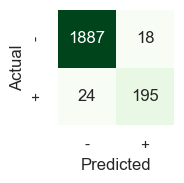

In [60]:
cm = confusion_matrix(Y_test,Y_test_pred)
plt.figure(figsize=(1.5, 1.5))
cm_plot = sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', cbar=False)
cm_plot.tick_params(left=False, bottom=False)
cm_plot.set(xticklabels=['-', '+'],yticklabels=['-', '+'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("figures/confusion_matrices_benchmark.svg", bbox_inches='tight')


In [61]:
24/(24+195) #fnr

0.1095890410958904

## FP analyses

In [62]:
benchmarking['pred_class'] = Y_test_pred

In [63]:
#save negative to do fp
benchmarking[benchmarking['class']==0][['Entry','class','pred_class']].to_csv('benchmark_negative.tsv',sep='\t',index=False)
fpr = np.round(cm[0][1]/(cm[0][1]+cm[0][0]),decimals=3)
print('General FPR: %s' % (fpr*100)+'%')

General FPR: 0.8999999999999999%


In [64]:
benchmark_neg = benchmarking[benchmarking['class']==0][['Entry','pred_class']]
benchmark_neg['TM']=0
with open('../von_heijne/fp_analysis/transmembrane_proteins.list') as file:
    tm_subset = [line.strip() for line in file]
benchmark_neg['TM'] = benchmark_neg['Entry'].isin(tm_subset).astype(int)

tp_subset = pd.read_table('../von_heijne/fp_analysis/transpeptide_proteins.list',sep='\t',names=['Entry','TP_location'])
benchmark_neg = pd.merge(benchmark_neg,tp_subset,on='Entry',how = 'outer')
benchmark_neg.insert(loc=3, column='TP', value=0)
benchmark_neg.loc[benchmark_neg['TP_location'].notna(), 'TP'] = 1
benchmark_neg

,Entry,pred_class,TM,TP,TP_location
0,Q9UT72,0,0,0,NaN
1,P30397,0,0,0,NaN
2,P25398,0,0,0,NaN
3,O15554,0,1,0,NaN
4,Q8IWZ6,0,0,0,NaN
...,...,...,...,...,...
1900,Q8VY77,0,1,0,NaN
1901,Q86X29,0,0,0,NaN
1902,Q7SHB2,0,0,0,NaN
1903,Q9H2W6,0,0,1,Mitochondrion


### FPR_TM

In [65]:
tm_FP = benchmark_neg[(benchmark_neg['TM']==1) & (benchmark_neg['pred_class']==1)].shape[0]
tm = benchmark_neg[(benchmark_neg['TM']==1)].shape[0]
FPR_tm =np.round((tm_FP/tm)*100,decimals=2)
print('FPR_TM: %s' % (FPR_tm)+'%')
#



FPR_TM: 6.25%


### FPR_TP

In [66]:
tp_FP = benchmark_neg[(benchmark_neg['TP']==1) & (benchmark_neg['pred_class']==1)].shape[0]
tp = benchmark_neg[(benchmark_neg['TP']==1)].shape[0]
FPR_tp =np.round((tp_FP/tp)*100,decimals=1)
print('FPR_TP: %s' % (FPR_tp)+'%')

FPR_TP: 0.5%


### FPR_TM and FPR_TP visualization


In [67]:

benchmark_neg.loc[benchmark_neg['pred_class'] == 1,'pred_class']='FP'
benchmark_neg.loc[benchmark_neg['pred_class'] == 0,'pred_class']='TN'
################################################################################################
tm_df = benchmark_neg[benchmark_neg['TM']==1][['pred_class','TM']]
tm_df['feature'] = 'Transmembrane'
#
tp_df = benchmark_neg[benchmark_neg['TP']==1][['pred_class','TP']]
tp_df['feature'] = 'Transit peptide'
#
tm_tp = pd.concat((tm_df[['pred_class','feature']],tp_df[['pred_class','feature']]),ignore_index=True)
tm_tp


,pred_class,feature
0,TN,Transmembrane
1,TN,Transmembrane
2,TN,Transmembrane
3,TN,Transmembrane
4,FP,Transmembrane
...,...,...
373,TN,Transit peptide
374,TN,Transit peptide
375,TN,Transit peptide
376,TN,Transit peptide


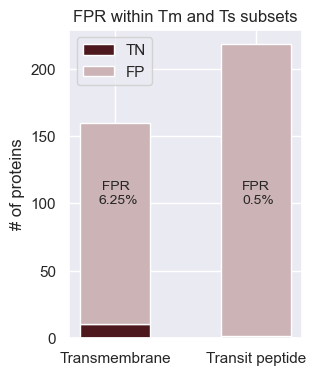

In [68]:

palette = {"TN":"#CCB3B5","FP":"#4D191F"}
sns.set_style("darkgrid")
plt.figure(figsize=(3, 4))
sns.histplot(data=tm_tp,x = 'feature',hue='pred_class',alpha=1,stat='count',multiple='stack',common_norm=False,shrink=0.5,palette=palette).set(title='FPR within Tm and Ts subsets',xlabel='',ylabel='# of proteins')
plt.legend(title='', labels=['TN', 'FP'])
plt.text(-0.12, 100, f' FPR\n{FPR_tm}%', fontsize=10)
plt.text(0.9, 100, f'FPR\n{FPR_tp}%', fontsize=10)
plt.savefig("figures/FPR_TMandFPR_TP.svg", bbox_inches='tight')


### Over-representation of transmembrane proteins in FP with respect to TN


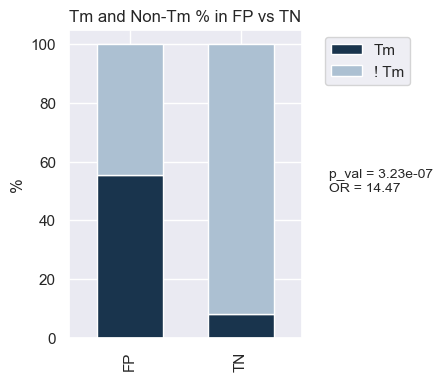

In [69]:

benchmark_neg.loc[benchmark_neg['TM'] == 1,'TM']='Transmembrane'
benchmark_neg.loc[benchmark_neg['TM'] == 0,'TM']='Non-Transmembrane'
benchmark_neg.loc[benchmark_neg['TP'] == 1,'TP']='Transit peptide'
benchmark_neg.loc[benchmark_neg['TP'] == 0,'TP']='Non-Transit peptide'
pivot_df = benchmark_neg.pivot_table(index='pred_class', columns='TM', values='Entry', aggfunc='count', fill_value=0)
columns_titles = ['Transmembrane',"Non-Transmembrane"] #change cols order
pivot_df = pivot_df.reindex(columns=columns_titles)
OR, p_val = fisher_exact(pivot_df)
p_val = '{:0.2e}'.format(p_val)

# 
pivot_df['Total'] = pivot_df['Transmembrane'] + pivot_df['Non-Transmembrane']
pivot_df['Transmembrane_Percentage'] = (pivot_df['Transmembrane'] / pivot_df['Total']) * 100
pivot_df['Non_transmembrane_Percentage'] = (pivot_df['Non-Transmembrane'] / pivot_df['Total']) * 100
from matplotlib.colors import ListedColormap

pivot_df = pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']]
palette = ['#19344D','#ACC0D2'] 
palette = ListedColormap(sns.color_palette(palette))
# Create the stacked barplot
plt.rcParams['figure.figsize'] = [3, 4]
pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']].plot(kind='bar', stacked=True, colormap=palette,width=0.6)
plt.title('Tm and Non-Tm % in FP vs TN')
plt.xlabel('')
plt.ylabel('%')
plt.legend(title='', loc='upper right', labels=['Tm', '! Tm'], bbox_to_anchor=(1.5, 1))
plt.text(1.8, 50, f'p_val = {p_val}\nOR = {OR:.2f}', fontsize=10)
plt.savefig("figures/ORofTMinFP.svg", bbox_inches='tight')


### Over-representation of transit peptide proteins in FP with respect to TN


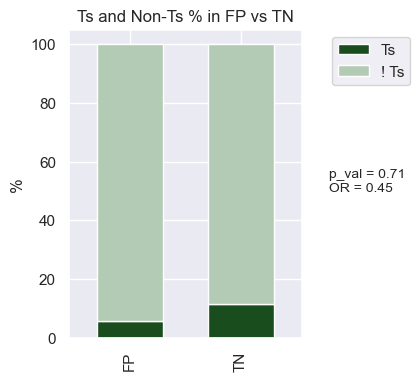

In [70]:

pivot_df2 = benchmark_neg.pivot_table(index='pred_class', columns='TP', values='Entry', aggfunc='count', fill_value=0)
#
columns_titles = ['Transit peptide',"Non-Transit peptide"]
pivot_df2=pivot_df2.reindex(columns=columns_titles)
OR, p_val = fisher_exact(pivot_df2)
# 
pivot_df2['Total'] = pivot_df2['Transit peptide'] + pivot_df2['Non-Transit peptide']
pivot_df2['Transit peptide_Percentage'] = (pivot_df2['Transit peptide'] / pivot_df2['Total']) * 100
pivot_df2['Non_Transit-peptide_Percentage'] = (pivot_df2['Non-Transit peptide'] / pivot_df2['Total']) * 100
pivot_df2
pivot_df = pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']]
palette = ['#194D1D','#B3CBB5']
palette = ListedColormap(sns.color_palette(palette))
#
plt.rcParams['figure.figsize'] = [3, 4]
pivot_df2[['Transit peptide_Percentage', 'Non_Transit-peptide_Percentage']].plot(kind='bar', stacked=True, colormap=palette,width=0.6)
plt.title('Ts and Non-Ts % in FP vs TN')
plt.xlabel('')
plt.ylabel('%')
plt.legend(title='', labels=['Ts', '! Ts'], bbox_to_anchor=(1.5, 1))
plt.text(1.8, 50, f'p_val = {p_val:.2f}\nOR = {OR:.2f}', fontsize=10)
plt.savefig("figures/ORofTPinFP.svg", bbox_inches='tight')


## FN analyses

#### Compare SP len of FNs VS TPs (Levene)

In [71]:
positives = benchmarking[benchmarking['class']==1]
#MWU pval
tp_len = np.array(positives[positives['pred_class']==1]['Signal peptide'])
fn_len = np.array(positives[positives['pred_class']==0]['Signal peptide'])

### normality test (Shapiro)

In [72]:
stat,fn_normality_p = shapiro(fn_len)
stat,tp_normality_p =shapiro(tp_len)
alpha = 0.05
if fn_normality_p > alpha:
    print('FN  looks Gaussian (fail to reject H0)')
else:
    print('FN does not look Gaussian (reject H0)')

if tp_normality_p > alpha:
    print('TP  looks Gaussian (fail to reject H0)')
else:
    print('TP does not look Gaussian (reject H0)')

FN does not look Gaussian (reject H0)
TP does not look Gaussian (reject H0)


In [73]:
stats, levene_p =levene(tp_len,fn_len)
stats, mwu_p = mannwhitneyu(tp_len,fn_len)
levene_p = '{:0.2e}'.format(levene_p)


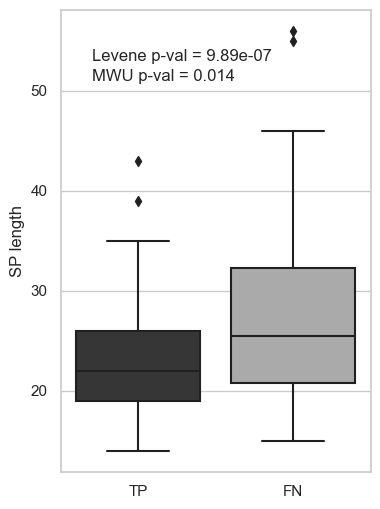

In [74]:
#
positives.loc[positives['pred_class']==1,'pred_class'] = 'TP'
positives.loc[positives['pred_class']==0,'pred_class'] = 'FN'
#
sns.set(rc={"figure.figsize":(4, 6)},style = 'whitegrid') 

sns.boxplot(data=positives, y="Signal peptide",x='pred_class',palette=['#363636','#AAAAAA'])
plt.text(-0.3, 53, f'Levene p-val = {levene_p}', fontsize=12)
plt.text(-0.3, 51, f'MWU p-val = {mwu_p:.3f}', fontsize=12)
plt.xlabel('')
plt.ylabel('SP length')
plt.savefig("figures/SP_lenFNvsTP.svg", bbox_inches='tight')





## FN vs TP N-COMP (:K)

In [75]:
euc_freq = {'M': 2.294367689100498, 'R': 5.28659479524882, 'F': 4.061144192552833, 'Q': 4.243880060805525, 'V': 6.195116301658416, 'I': 5.2782038449558515, 'A': 6.964597776165187, 'T': 5.474762802434163, 'S': 8.167359184996902, 'Y': 2.9958458540998643, 'P': 5.352921291956602, 'G': 6.4210338295777225, 'D': 5.162172071912705, 'L': 9.66490107039764, 'N': 4.366213941365931, 'K': 5.957815728327312, 'E': 6.579050194696789, 'H': 2.411104159651493, 'W': 1.2401562853801333, 'C': 1.882758924715616}
euc_freq = pd.DataFrame(euc_freq.items(),columns=['aa','%'])

In [76]:
#TP
#note that are present Z,U,X letters too
tp_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='TP':
        for char in row["Sequence"][:K]:
            tp_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    tp_comp.pop(key)
#normalize the frequencies
factor=sum(tp_comp.values())/100
for k in tp_comp.keys():
    tp_comp[k] = tp_comp[k]/factor
#FN
#note that are present Z,U,X letters too
fn_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='FN':
        for char in row["Sequence"][:K]:
            fn_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    fn_comp.pop(key)
#normalize the frequencies
factor=sum(fn_comp.values())/100
for k in fn_comp.keys():
    fn_comp[k] = fn_comp[k]/factor

In [77]:
amino_acid_groups = {
    'polar': ['S', 'T', 'N', 'Q', 'H','C'],
    'apolar': ['G', 'A', 'V', 'P', 'L', 'I', 'M'],
    'charged': [ 'D', 'E', 'K', 'R'],
    'aromatic': ['F', 'W', 'Y']}
aa_order = ['G','A','V','P','L','I','M','D','E','K','R','F','W','Y','S','T','C','N','Q','H']     
tp_comp = pd.DataFrame(tp_comp.items(),columns=['aa','%'])
fn_comp = pd.DataFrame(fn_comp.items(),columns=['aa','%'])
tp_comp['set'] = 'TP'
fn_comp['set'] = 'FN'
df_composition = pd.concat((tp_comp, fn_comp),ignore_index=True)

euc_freq['group'] = euc_freq['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))
df_composition['group'] = df_composition['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))


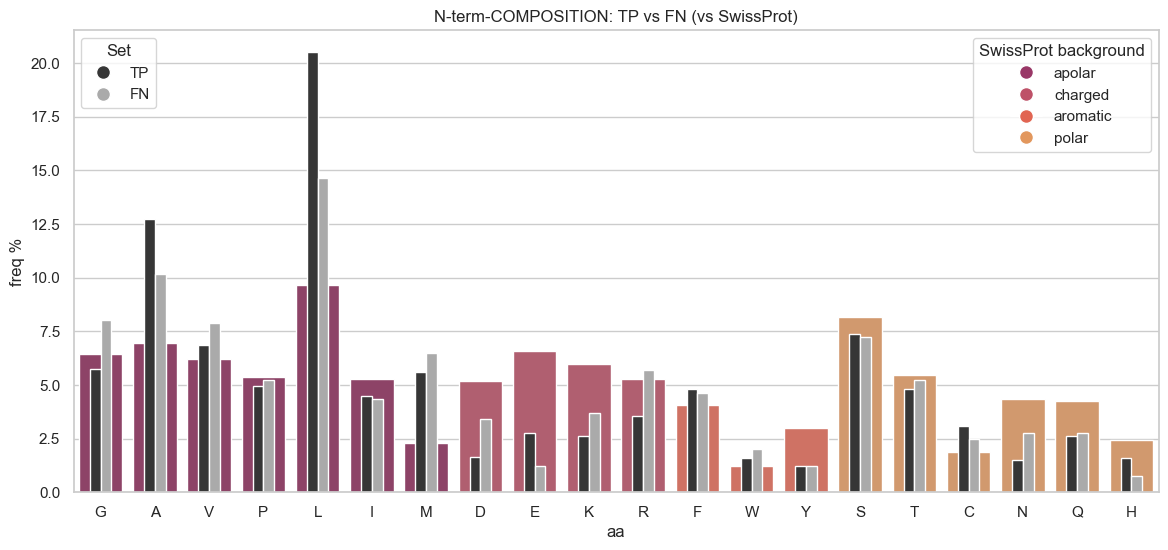

In [78]:
sns.set(rc={"figure.figsize":(14, 6)},style = 'whitegrid') 
sns.barplot(data=euc_freq,x='aa',y='%',width=0.8,order=aa_order,hue='group',alpha=1,dodge=False,palette=["#993767","#be5168","#e16552","#e2975d","#e9d78e","#3b8d9c"])
sns.barplot(data=df_composition,x='aa',y='%',hue='set',width=0.4,order=aa_order,palette=['#363636','#AAAAAA']).set(title='N-term-COMPOSITION: TP vs FN (vs SwissProt)', xlabel='aa', ylabel='freq %')
# Create custom legend handles for the first legend
handles1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(euc_freq['group'].unique(), ["#993767", "#be5168", "#e16552", "#e2975d", "#e9d78e", "#3b8d9c"])]
# Create custom legend handles for the second legend
handles2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(df_composition['set'].unique(), ['#363636','#AAAAAA'])]
# Create separate legends
legend1 = plt.legend(title="SwissProt background", handles=handles1, loc='upper right')
legend2 = plt.legend(title="Set", handles=handles2, loc='upper left')
# Add the legends to the plot
plt.gca().add_artist(legend1)
plt.savefig('figures/comp.svg', bbox_inches='tight')

### C-COMP 

In [79]:
#TP
#note that are present Z,U,X letters too
tp_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='TP':
        for char in row["Sequence"][K:]:
            tp_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    tp_comp.pop(key)
#normalize the frequencies
factor=sum(tp_comp.values())/100
for k in tp_comp.keys():
    tp_comp[k] = tp_comp[k]/factor
#FN
#note that are present Z,U,X letters too
fn_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='FN':
        for char in row["Sequence"][K:]:
            fn_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    fn_comp.pop(key)
#normalize the frequencies
factor=sum(fn_comp.values())/100
for k in fn_comp.keys():
    fn_comp[k] = fn_comp[k]/factor


In [80]:
amino_acid_groups = {
    'polar': ['S', 'T', 'N', 'Q', 'H','C'],
    'apolar': ['G', 'A', 'V', 'P', 'L', 'I', 'M'],
    'charged': [ 'D', 'E', 'K', 'R'],
    'aromatic': ['F', 'W', 'Y']}
aa_order = ['G','A','V','P','L','I','M','D','E','K','R','F','W','Y','S','T','C','N','Q','H']     
tp_comp = pd.DataFrame(tp_comp.items(),columns=['aa','%'])
fn_comp = pd.DataFrame(fn_comp.items(),columns=['aa','%'])
tp_comp['set'] = 'TP'
fn_comp['set'] = 'FN'
df_composition = pd.concat((tp_comp, fn_comp),ignore_index=True)

euc_freq['group'] = euc_freq['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))
df_composition['group'] = df_composition['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))


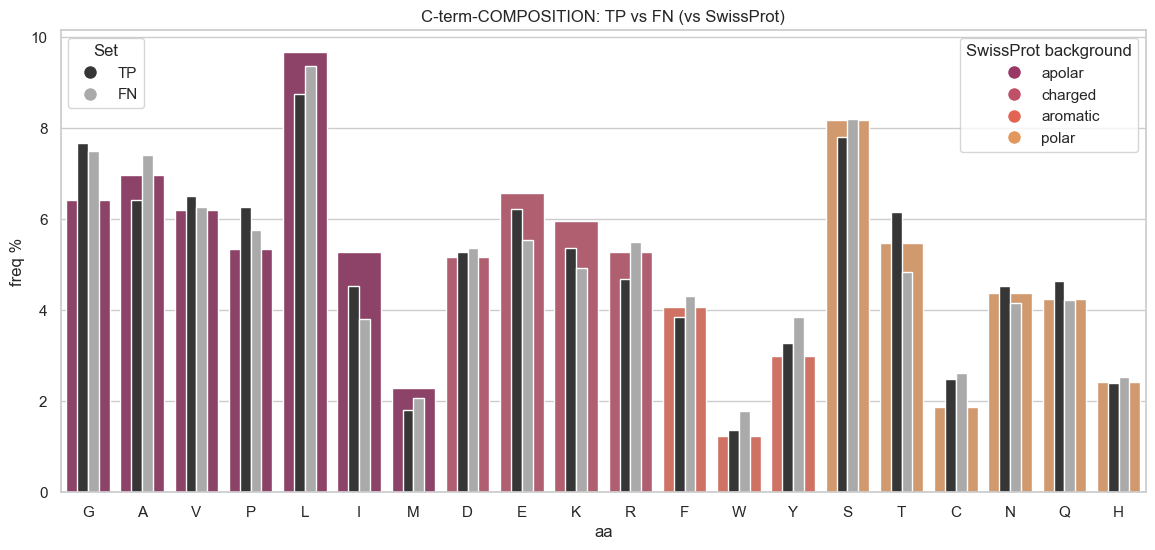

In [81]:
sns.set(rc={"figure.figsize":(14, 6)},style = 'whitegrid') 
sns.barplot(data=euc_freq,x='aa',y='%',width=0.8,order=aa_order,hue='group',alpha=1,dodge=False,palette=["#993767","#be5168","#e16552","#e2975d","#e9d78e","#3b8d9c"])
sns.barplot(data=df_composition,x='aa',y='%',hue='set',width=0.4,order=aa_order,palette=['#363636','#AAAAAA']).set(title='C-term-COMPOSITION: TP vs FN (vs SwissProt)', xlabel='aa', ylabel='freq %')
# Create custom legend handles for the first legend
handles1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(euc_freq['group'].unique(), ["#993767", "#be5168", "#e16552", "#e2975d", "#e9d78e", "#3b8d9c"])]
# Create custom legend handles for the second legend
handles2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(df_composition['set'].unique(), ['#363636','#AAAAAA'])]
# Create separate legends
legend1 = plt.legend(title="SwissProt background", handles=handles1, loc='upper right')
legend2 = plt.legend(title="Set", handles=handles2, loc='upper left')
# Add the legends to the plot
plt.gca().add_artist(legend1)
#plt.savefig('figures/comp.svg')